# Fitting COVID19 trends using Bayesian method

In this assignment, our goal is to fit the COVID 19 trends (confirmed cases of COVID 19 as a function of date) using the generalized growth model given by

\begin{align}
\frac{d C(t)}{dt} = r C(t)^p, \label{eq:ode} \tag{1}
\end{align}

where $t \in [0,T]$ is the time (in units of days), $r \geq 0$ is the growth rate, $p
\in [0,1]$ is the 'decceleration of growth' parameter, see **Viboud et al 2015**. Special cases: $p = 0$ gives linear growth model and $p=1$ gives exponential growth model. 

$C : [0,T] \to [0, \infty)$ is the total confirmed COVID 19 cases at time $t$. When $0 < p < 1$, Eq (1) can be solved to get 

\begin{align}
C(t) = \left( \frac{r}{m}t + (C_0)^{1/m} \right)^m, \label{eq:model} \tag{2}
\end{align}

where $m = 1/(1 - p)$ and $C_0 = C(0)$ is the initial condition. For special cases $p=0$ and $p=1$, $C$ can be found easily.

# Problem

We cosider COVID 19 data at discrete times $\bar{t} = (t_1=0, t_2=1, ..., t_N=83)$, where $N = 84$, and corresponding total confirmed cases $Y(\bar{t}) = (Y_1, Y_2, ..., Y_N)$.

Model prediction is $C(\bar{t}) = (C(t_1), C(t_2), ..., C(t_N))$ where $C(t_i)$ is given by Eq (2). The model parameters are $\theta = (r, p)$. Take uniform prior for $\theta$ and consider a Guassian noise with zero mean and standard deviation $\sigma$. Divide the data in calibration and validation by taking first $N_c = 50$ as the calibration data and rest $N_v = N - N_c$ as validation data. You can also try different priors for parameters and divide data differently in calibration and validation set.

Problem: Predict the total confirmed cases at $T = 100$ day for three countries US, Japan, and South Korea.

## Data
Data for current epidemic COVID 19 can be found in several places such as:

- [datasets/covid-19](https://github.com/datasets/covid-19)

- [CSSEGISandData/COVID-19](https://github.com/CSSEGISandData/COVID-19)

- [nytimes/covid-19-data](https://github.com/nytimes/covid-19-data)


In [StudyCovid19](https://github.com/prashjha/StudyCovid19) you will find python scripts to process data and this notebook in directory `process/bayesian`.


Below we plot the confirmed cases for various countries

In [1]:
import pandas as pd
import sys
sys.path.insert(0,'../')

In [2]:
# # from data import plot_countries_all_plus_normalize_1 as plot
# # from data import save_country_data_1 as save
# df = pd.read_csv('../../data/datasets/time-series-19-covid-combined.csv')
# # plot
# plot(df, ['US', 'Japan', 'Korea, South'])
# # save data
# save(df, ['US', 'Japan', 'Korea, South'])

## Report
I choose South Korea as an example, applying the calibration and validation, and giving QoI's expectation and its distribution.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from models import model1, model2, model3

In [4]:
# prepare 
T = 100

def prepare(country, model, noise_arg=1.):
    # open file
    df = pd.read_csv(country+'.csv',header=None)
    data = np.array(df)

    # split into calibration and validation sets
    train_size = 60
    data_c = data[:train_size,:]
    data_v = data[train_size:,:]

    # # model 1
    # model = model1
    # fixed_param = [data[0,1]]
    # trans_param[0.01,0.0001]
    # param_init = [0.5,0.5]  
    # def prior(theta):
    #     if theta[0]<0 or theta[1]<0 or theta[1]>1:   # r>0  0<=p<=1
    #         return 1e-8
    #     return 1

    # prepare model 3
    if model == model3:
        # prepare uniform prior
        def prior_c(theta):
            if theta[0]<0 or theta[1]<0:   # a>0,b>0
                return 0
            return 1
        
        # prepare arguments used in the model
        # I want to set [fix_params, trans_param, init_guess] for each country
        if country=='Korea, South':
            model_args = [[data[0,1],T,4], [1,.001], [12000,8]]  
        #         model_args['Korea, South'] = [ [[data[0,1],100.,4], [1,.001], [19000,10.6]], \
        #                                    [[data[0,1],100.,4], [1,.001], [10740,6.5]] ]
        #     # model_args['US'] = [ [[data[0,1],100.,2], [100,1], [575000,20]], \
        #     #                      [[data[0,1],100.,2], [100,1], [775000,12]] ]  # not well
        #     model_args['US'] = [ [[data[0,1],100.,4], [100,.1], [25000,41.6]], \
        #                          [[data[0,1],100.,4], [1,.001], [646300,132.5]] ]
        #     model_args['Japan'] = [ [[data[0,1],100.,4], [10,.01], [1000,8]], \
        #                             [[data[0,1],100.,4], [10,.01], [7300,135]] ]
        
        
    return data_c, data_v, prior_c, model_args

In [5]:
# prepare MCMC
def acceptance_rule(x, x_new):     # acceptance rule under log likelihood
    if x_new>x:
        return True
    else:
        accept = np.random.uniform(0,1)
        # Since we did a log likelihood, we need to exponentiate in order to compare to the random number
        # less likely x_new are less likely to be accepted
        return (accept < (np.exp(x_new-x)))
    
def metropolis_hastings(log_likelihood,prior, transition_model, param_init,iterations,data,acceptance_rule):
    # likelihood_computer(x,data): returns the likelihood that these parameters generated the data
    # transition_model(x): a function that draws a sample from a symmetric distribution and returns it
    # param_init: a starting sample
    # iterations: number of accepted to generated
    # data: the data that we wish to model
    # acceptance_rule(x,x_new): decides whether to accept or reject the new sample
    theta = param_init
    accepted = []
    rejected = []   
    for i in range(iterations):
        theta_new = transition_model(theta)    
        lik = log_likelihood(theta,data)
        lik_new = log_likelihood(theta_new,data) 
        if (acceptance_rule(lik + np.log(prior(theta)),lik_new + np.log(prior(theta_new)))):            
            theta = theta_new
            accepted.append(theta_new)
        else:
            rejected.append(theta_new)            
    return np.array(accepted), np.array(rejected)


In [6]:
def show_mcmc(accepted, rejected):
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(1,1,1)
    ax.plot(accepted[:,0], accepted[:,1], label="Path")
    ax.plot(accepted[:,0], accepted[:,1], 'b.', label='Accepted',alpha=0.3)
    ax.plot(rejected[:,0], rejected[:,1], 'rx', label='Rejected',alpha=0.3)
    ax.set_xlabel("first parameter")
    ax.set_ylabel("second parameter")
    ax.legend()
    ax.set_title("MCMC sampling with Metropolis-Hastings. All samples are shown.") 


In [7]:
def burn_accepted(accepted, burn_in=0.5, show=True):
    total_iters = accepted.shape[0]
    burnin_iters = int(burn_in*accepted.shape[0])
    accepted_burnin = accepted[:burnin_iters,:]
    accepted_burned = accepted[burnin_iters:,:]

    
    if show:
        fig = plt.figure(figsize=(15,7))
        ax = fig.add_subplot(1,2,1)
        ax.plot(range(burnin_iters),accepted_burnin[:,0], color='gray', label='burn_in')
        ax.plot(range(burnin_iters,total_iters),accepted_burned[:,0], color='blue', label='burned')
        ax.set_title("Trace for #1 parameter")
        ax.set_xlabel("Iteration")
        ax.set_ylabel("#1 parameter")
        ax.legend()
        ax = fig.add_subplot(1,2,2)
        ax.hist(accepted_burned[:,0], bins=20, density=True)
        ax.set_ylabel("Frequency (normed)")
        ax.set_xlabel("#1 parameter")
        ax.set_title("Histogram of #1 parameter (burned)")
        fig.tight_layout()

        fig = plt.figure(figsize=(15,7))
        ax = fig.add_subplot(1,2,1)
        ax.plot(range(burnin_iters),accepted_burnin[:,1], color='gray', label='burn_in')
        ax.plot(range(burnin_iters,total_iters),accepted_burned[:,1], color='blue', label='burned')
        ax.set_title("Trace for #2 parameter")
        ax.set_xlabel("Iteration")
        ax.set_ylabel("#2 parameter")
        ax = fig.add_subplot(1,2,2)
        ax.hist(accepted_burned[:,1], bins=20, density=True)
        ax.set_ylabel("Frequency (normed)")
        ax.set_xlabel("#2 parameter")
        ax.set_title("Histogram of #2 parameter (burned)")
        fig.tight_layout()
     
    return accepted_burned

## Let's start!

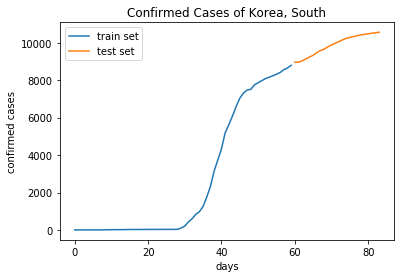

In [8]:
country = 'Korea, South'
model = model3
noise_arg = 1.
data_c, data_v, prior_c, model_args = prepare(country, model, noise_arg)

plt.plot(data_c[:,0],data_c[:,1], label="train set")
plt.plot(data_v[:,0],data_v[:,1], label="test set")
plt.xlabel("days")
plt.ylabel("confirmed cases")
plt.legend()
plt.title("Confirmed Cases of "+ country) 
plt.show()

In [9]:
## Calibration
fix_params = model_args[0]  
trans_param = model_args[1]
param_init = model_args[2]

transition_model = lambda theta: np.random.normal(theta,trans_param,(2,))

def log_likelihood_c(theta, data):
    tdata = data[:,0]
    ydata = data[:,1]
    return np.sum(-np.log(noise_arg * np.sqrt(2*np.pi) )-((ydata-model(theta,tdata,fix_params))**2) / (2*noise_arg**2))
    
accepted, rejected = metropolis_hastings(log_likelihood_c,prior_c,transition_model,param_init,50000,data_c,acceptance_rule)
print('# accepted = ' + str(accepted.shape[0]))

# accepted = 12017


[1.22569285e+04 7.57307185e+00]
[[4.07200126e-01 2.99636252e-04]
 [2.99636252e-04 3.73845075e-07]]


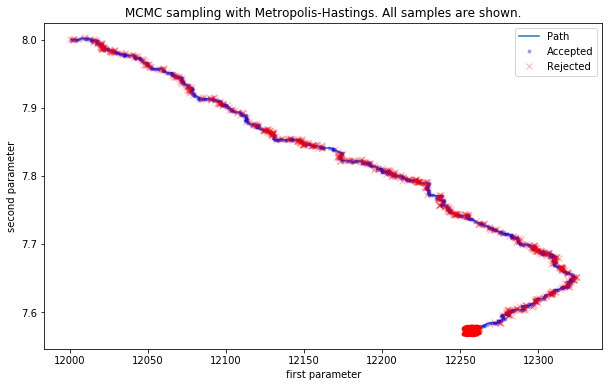

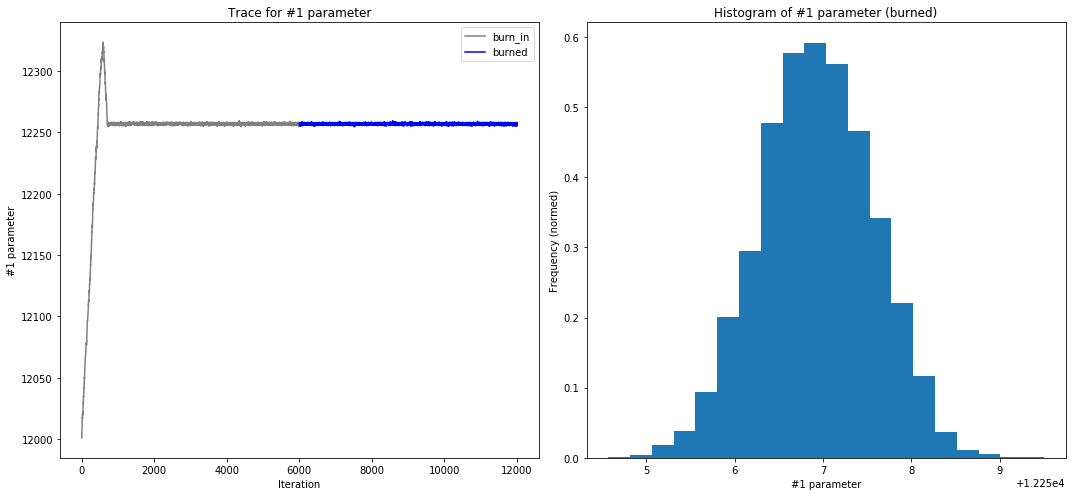

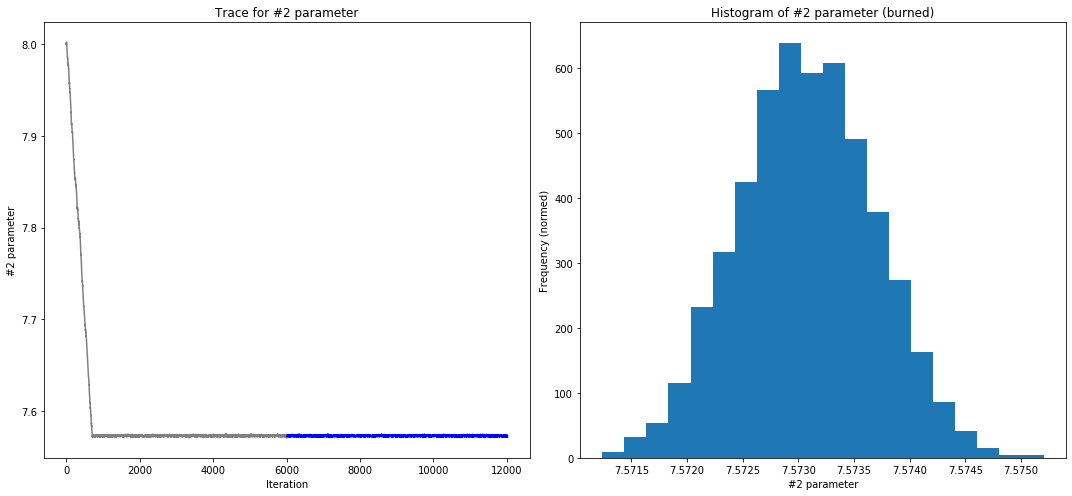

In [10]:
show_mcmc(accepted, rejected)
accepted_burned = burn_accepted(accepted, burn_in=0.5, show=True)

cal_mean = np.mean(accepted_burned, axis=0)
cal_cov = np.cov(accepted_burned.T)
print(cal_mean)
print(cal_cov)

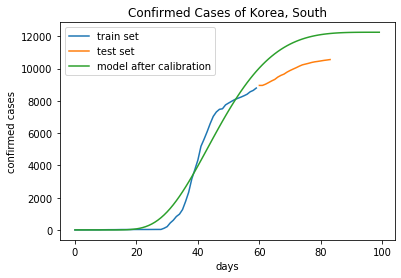

In [11]:
# plot the curve
plt.plot(data_c[:,0],data_c[:,1], label="train set")
plt.plot(data_v[:,0],data_v[:,1], label="test set")
plt.plot(np.arange(T), model(cal_mean, np.arange(T), fix_params), label="model after calibration")

plt.xlabel("days")
plt.ylabel("confirmed cases")
plt.legend()
plt.title("Confirmed Cases of "+ country) 
plt.show()

## Validation

In [12]:
from scipy.stats import multivariate_normal
# multivariate_normal.pdf(cal_mean, mean=cal_mean, cov=cal_cov)
# # plot prior of validation 

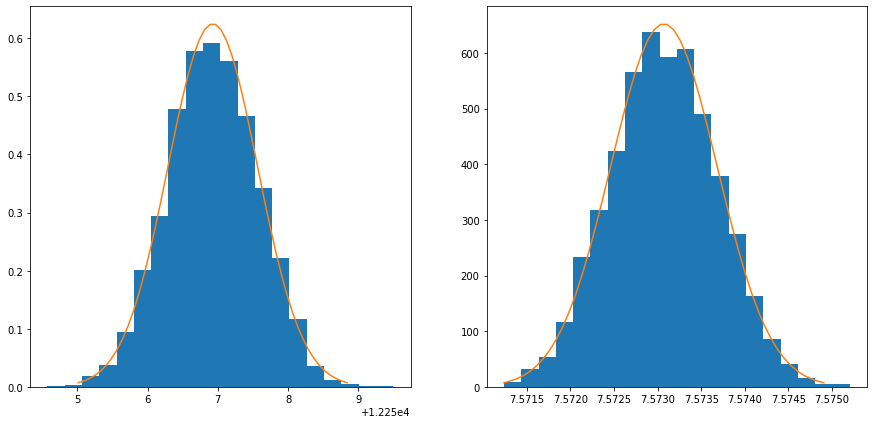

In [13]:
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(1,2,1)
ax.hist(accepted_burned[:,0], bins=20, density=True)
x0 = np.linspace(cal_mean[0]-3*np.sqrt(cal_cov[0,0]),cal_mean[0]+3*np.sqrt(cal_cov[0,0]))
ax.plot(x0,multivariate_normal.pdf(x0, mean=cal_mean[0], cov=cal_cov[0,0]), label="gaussian approx")

ax = fig.add_subplot(1,2,2)
ax.hist(accepted_burned[:,1], bins=20, density=True)
x1 = np.linspace(cal_mean[1]-3*np.sqrt(cal_cov[1,1]),cal_mean[1]+3*np.sqrt(cal_cov[1,1]))
ax.plot(x1,multivariate_normal.pdf(x1, mean=cal_mean[1], cov=cal_cov[1,1]), label="gaussian approx")

# plt.xlabel("days")
# plt.ylabel("confirmed cases")
# plt.legend()
# plt.title("Confirmed Cases of "+ country) 
plt.show()

In [14]:
param_init = cal_mean

def prior_v(theta):
    return multivariate_normal.pdf(theta, mean=cal_mean, cov=cal_cov)

In [15]:
prior_v(np.array([12233,7.5575]))

3.975301027327995e-309

In [16]:
def log_likelihood_v(theta, data):
    tdata = data[:,0]
    ydata = data[:,1]
    return np.sum(-np.log(noise_arg * np.sqrt(2*np.pi) )-((ydata-model(theta,tdata,fix_params))**2) / (2*noise_arg**2))

trans_param_v = [np.sqrt(cal_cov[0,0])/10, np.sqrt(cal_cov[1,1])/10]
transition_model_v = lambda theta: np.random.normal(theta,trans_param_v,(2,))
    

In [31]:
# theta_old = np.array([12233, 7.5573])
theta_old = accepted[-1]
# theta_old = cal_mean

theta_new = transition_model_v(theta_old)
print(theta_old)
print(theta_new)
print(theta_new-theta_old)

[1.22322431e+04 7.55591948e+00]
[1.22321341e+04 7.55588728e+00]
[-1.08927634e-01 -3.22049754e-05]


In [35]:
print(prior_v(theta_old))
print(np.log(prior_v(theta_old)))
print(log_likelihood_v(theta_old, data_v))
print(prior_v(theta_new))
print(np.log(prior_v(theta_new)))
print(log_likelihood_v(theta_new, data_v))

5e-324
-744.4400719213812
-28796858.224173974
0.0
-inf
-28793183.55445808


/Users/mathew/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


In [25]:
accepted, rejected = metropolis_hastings(log_likelihood_v,prior_v,transition_model_v,param_init,100000,data_v,acceptance_rule)
print('# accepted = ' + str(accepted.shape[0]))

/Users/mathew/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log


# accepted = 699


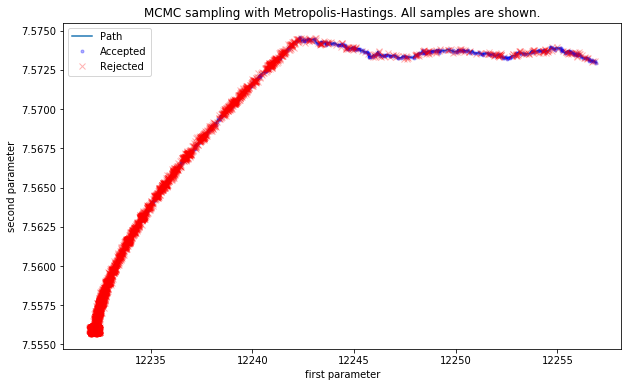

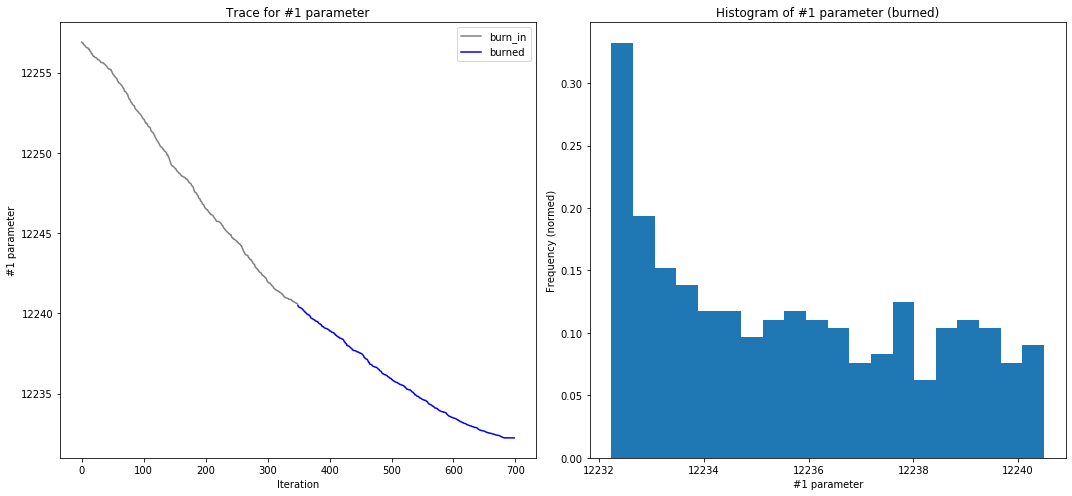

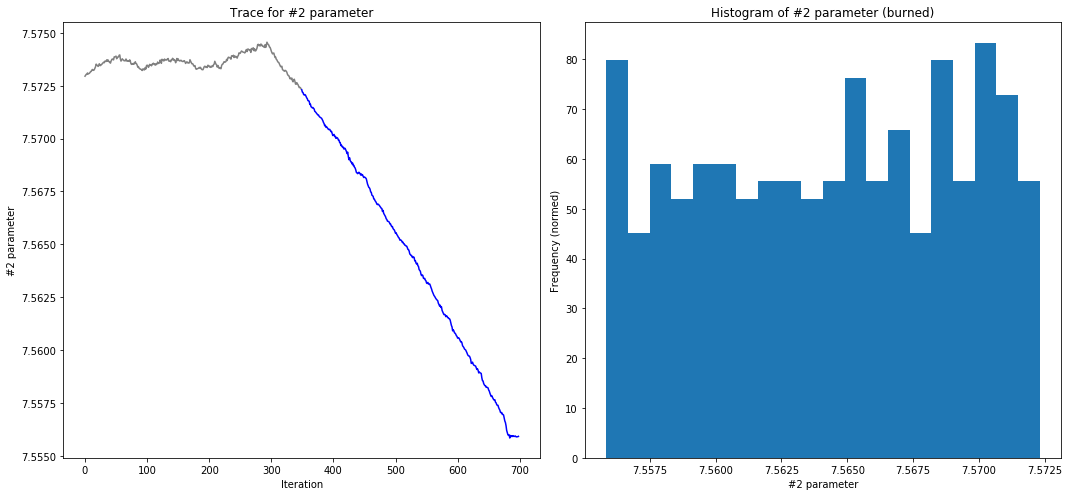

In [26]:
show_mcmc(accepted, rejected)
accepted_burned = burn_accepted(accepted, burn_in=0.5, show=True)

# val_mean = np.mean(accepted_burned, axis=0)
# val_cov = np.cov(accepted_burned.T)
# print(val_mean)
# print(val_cov)

## Show fitting curves and QoI

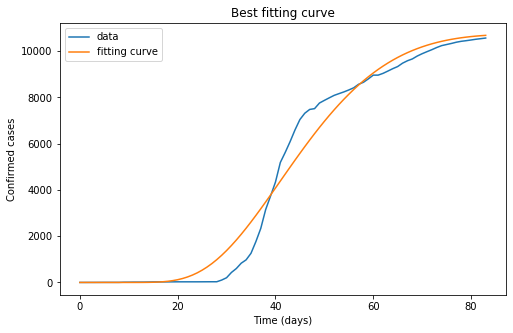

In [12]:
fig = plt.figure(figsize=(8,5))
plt.plot(data[:,0], data[:,1], label='data')
plt.plot(data[:,0], model(theta_opt,data[:,0],fix_params), label='fitting curve')

plt.title('Best fitting curve')
plt.xlabel('Time (days)')
plt.ylabel('Confirmed cases')
plt.legend()

10738.544662491695


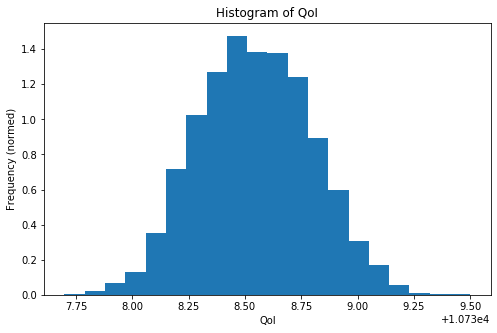

In [13]:
QoIs = [model(theta,[100],fix_params)[0] for theta in accepted_burned]

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
ax.hist(QoIs, bins=20, density=True)
ax.set_ylabel("Frequency (normed)")
ax.set_xlabel("QoI")
ax.set_title("Histogram of QoI")

QoI = sum(QoIs)/len(QoIs)
print(QoI)

# References

- **Viboud et al 2015** Viboud, C., Simonsen, L. and Chowell, G., 2016. A generalized-growth model to characterize the early ascending phase of infectious disease outbreaks. Epidemics, 15, pp.27-37.